In [2]:
!pip install pytorch-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 35.8 MB/s eta 0:00:00


In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchmetrics import Accuracy, Precision, Recall
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Фиксация random_state для воспроизводимости

In [74]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

Функция для препроцессинга данных

In [75]:
def prepare_data():
    # Определяем трансформации для данных (аугментация и нормализация)
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Случайное отражение по горизонтали
        transforms.RandomCrop(32, padding=4),  # Случайное обрезание с добавлением заполнения
        transforms.ToTensor(),  # Преобразование изображений в тензоры
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация значений пикселей
    ])

    # Загрузка тренировочного набора CIFAR-100
    cifar100 = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    # Загрузка тестового набора CIFAR-100
    test_data = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

    # Разделение тренировочного набора на обучающую и валидационную выборки
    train_size = int(0.8 * len(cifar100))
    val_size = len(cifar100) - train_size
    train_data, val_data = random_split(cifar100, [train_size, val_size])

    # Создание загрузчиков данных
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)  # Загрузчик обучающей выборки
    val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=4)  # Загрузчик валидационной выборки
    test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)  # Загрузчик тестовой выборки

    return train_loader, val_loader, test_loader

Реализация модели AlexNet

In [88]:
class AlexNet(pl.LightningModule):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        # Слои для извлечения признаков (feature extractor)
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),  # Первый сверточный слой (адаптирован)
            nn.ReLU(inplace=True),  # Функция активации ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),  # Первый слой подвыборки (MaxPooling)
            nn.Conv2d(96, 256, kernel_size=3, stride=1, padding=1),  # Второй сверточный слой
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Второй слой подвыборки
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),  # Третий сверточный слой
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),  # Четвертый сверточный слой
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),  # Пятый сверточный слой
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Третий слой подвыборки
        )
        # Полносвязные слои для классификации
        self.classifier = nn.Sequential(
            nn.Dropout(),  # Dropout для регуляризации
            nn.Linear(256 * 4 * 4, 4096),  # Первый полносвязный слой (размер пересчитан)
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),  # Второй полносвязный слой
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)  # Выходной слой с числом классов
        )

        # Метрики
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        # Прямой проход через feature extractor и classifier
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        # Шаг обучения
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        acc = self.train_accuracy(outputs, targets)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Шаг валидации
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        acc = self.val_accuracy(outputs, targets)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # Шаг тестирования
        inputs, targets = batch
        outputs = self(inputs)
        acc = self.test_accuracy(outputs, targets)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        # Настройка оптимизатора
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

Готовим данные

In [89]:
train_loader, val_loader, test_loader = prepare_data()

Files already downloaded and verified
Files already downloaded and verified


Создаем модель

In [90]:
model = AlexNet(num_classes=100)

Настраиваем трейнер

In [97]:
trainer = Trainer(max_epochs=30, accelerator="gpu", devices=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Логируем лосс

In [98]:
losses = []
val_losses = []

class LossLogger(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        losses.append(trainer.callback_metrics["train_loss"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_losses.append(trainer.callback_metrics["val_loss"].item())

In [99]:
trainer.callbacks.append(LossLogger())

In [100]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | features       | Sequential         | 3.3 M  | train
1 | classifier     | Sequential         | 34.0 M | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
37.3 M    Trainable params
0         Non-trainable params
37.3 M    Total params
149.176   Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [103]:
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.42989999055862427    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.42989999055862427}]

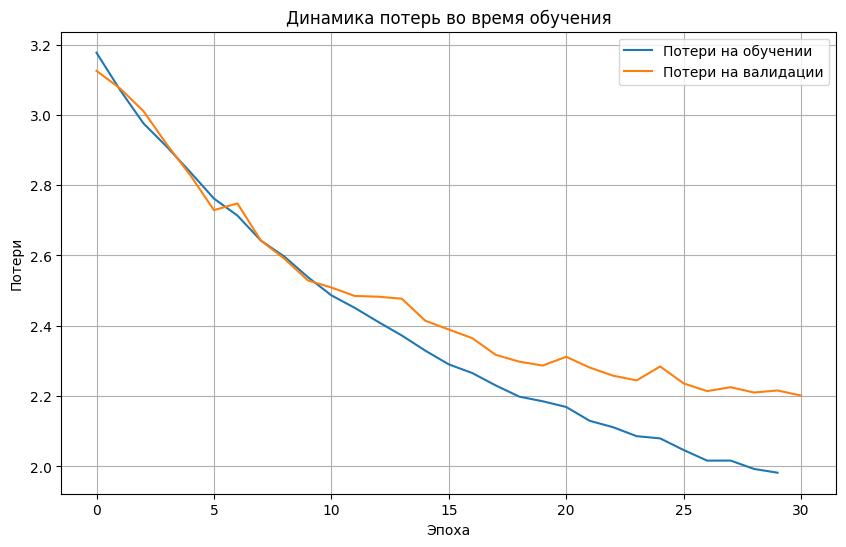

In [104]:
import matplotlib.pyplot as plt

# Визуализация лосса
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Потери на обучении")
plt.plot(val_losses, label="Потери на валидации")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Динамика потерь во время обучения")
plt.legend()
plt.grid()
plt.show()


Я проверил 3 метрики на тесте на 60 эпохах


Accuracy является наиболее релевантной метрикой, так как задача — это равноважная классификация 100 классов.
Precision и Recall также полезны для анализа, если есть перекосы в ошибках между классами.
В нашем случае, Accuracy = 44.85%, что является разумной отправной точкой.

[{'test_acc': 0.44850000739097595,
  'test_precision': 0.37667158246040344,
  'test_recall': 0.37664639949798584}]